This is my last try and best model so far, It takes the previous years information and creates 12 different model again. But this time I monitored the loss and created a better model

In [46]:
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras import callbacks
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import joblib
import os

tf.config.run_functions_eagerly(True) #Enabling immediate computation mode in TensorFlow

# This is the data preparation I explained this in the 'drawingGraph.ipynb' file
data =  pd.read_csv("monatszahlen2209_verkehrsunfaelle.csv")
data = data.iloc[:, :5] 
data.rename(columns={'MONATSZAHL': 'category'
                  , 'AUSPRÄGUNG': 'accidentType'
                  , 'JAHR': 'year'
                  , 'MONAT': 'month'
                  , 'WERT': 'value'}, inplace=True)
data = data[data["month"].str.lower() != "summe"]
data['month'] = data['month'].apply(lambda x: int(str(x)[-2:]) if str(x).isdigit() else x)
data = data[data['accidentType'] == 'insgesamt']
data = data[data['category'] == 'Alkoholunfälle']
toBeUsedForTesting = data
data = data[data['year'] <= 2020]
data['Date'] = pd.to_datetime(data['year'].astype(str) + "-" + data['month'].astype(str) + "-01")

In [33]:
#Creating LSTM model again
def create_model(past_months):
    model = Sequential() 
    model.add(LSTM(50, return_sequences=True, input_shape=(1, past_months))) # 50 neuron layer
    model.add(Dropout(0.2))  # Adding a Dropout layer to avoid overfitting
    model.add(LSTM(50))  # Adding another LSTM layer with 50 neurons
    model.add(Dropout(0.2))  # Adding another Dropout layer
    model.add(Dense(1)) 
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01)) 
    return model

In [34]:
# This is again like the previous model I am creating the previous steps and the 
# value that will be made predictions about
def dataset_creation(data, pre_steps):
    X, Y = [], []
    for i in range(len(data)-pre_steps-1):
        X.append(data[i:(i+pre_steps)])
        Y.append(data[i + pre_steps])
    return np.array(X), np.array(Y)

In [35]:
scalers = {} #  dictionary to hold trained minmax scaler objects. 
models = {} #  dictionary to hold trained model objects. 
data_per_month = dict() # dictionary to hold the data each month

In [36]:
for month in range(1, 13): # I am doing it for every month
    data_per_month[month] = data[(data['Date'].dt.month == month)].copy() # make the numbers equal to the current month index and be sure, copy is to be sure not to change the original data
    data_per_month[month].sort_values(by="Date", inplace=True) # sort the values
    scaler = MinMaxScaler(feature_range=(-1, 1)) # scaling the data to the range of -1 to 1
    data_per_month[month]['value'] = scaler.fit_transform(data_per_month[month]['value'].values.reshape(-1,1))
    scalers[month] = scaler #keep the scalers to unscale in the future


In [37]:
models = dict() # dictionary to hold the models for each month
past_months = 7 # it will take the value of the past 7 years on the same month

early_stopping = callbacks.EarlyStopping( # Because I increased the epoch I put the early stopping to prevent overfitting
    monitor='loss',  # monitoring the 'loss' of the model during training
    #This means for 20 steps if loss does not decrease more than the delta number stop
    min_delta=0.00001, 
    patience=20, 
    restore_best_weights=True, # the model weights with the best value monitored will be restored this is why I put immediate computation
)

In [38]:
# Creating a model for each month and training it
for month in range(1, 13):
    data_this_month = data_per_month[month]['value'].values
    trainX, trainY = dataset_creation(data_this_month, past_months)
    trainX = trainX.reshape((trainX.shape[0], 1, past_months))
    model = create_model(past_months)     # Initialize a model and train it
    
    # This allows us to reuse this model later for the best version
    checkpoint = callbacks.ModelCheckpoint( # adding ModelCheckpoint callback that will save the model architecture + weights to a file.
        f'models\model4/model_{month}.h5',  
        monitor='loss', 
        save_best_only=True  
    )

    # valisation split is Fraction of the training data to be used as validation data
    model.fit(trainX, trainY, epochs=200, batch_size=4, verbose=2, validation_split=0.2, callbacks=[early_stopping])
    models[month] = model

Epoch 1/200


c:\Users\Z004RE4V\AppData\Local\anaconda3\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
c:\Users\Z004RE4V\AppData\Local\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


3/3 - 0s - loss: 0.5716 - val_loss: 0.2870 - 248ms/epoch - 83ms/step
Epoch 2/200
3/3 - 0s - loss: 0.2495 - val_loss: 0.0174 - 184ms/epoch - 61ms/step
Epoch 3/200
3/3 - 0s - loss: 0.1115 - val_loss: 0.2613 - 173ms/epoch - 58ms/step
Epoch 4/200
3/3 - 0s - loss: 0.0828 - val_loss: 0.0283 - 155ms/epoch - 52ms/step
Epoch 5/200
3/3 - 0s - loss: 0.0318 - val_loss: 0.0142 - 148ms/epoch - 49ms/step
Epoch 6/200
3/3 - 0s - loss: 0.0437 - val_loss: 0.0346 - 152ms/epoch - 51ms/step
Epoch 7/200
3/3 - 0s - loss: 0.0538 - val_loss: 0.0137 - 180ms/epoch - 60ms/step
Epoch 8/200
3/3 - 0s - loss: 0.0226 - val_loss: 0.0027 - 142ms/epoch - 47ms/step
Epoch 9/200
3/3 - 0s - loss: 0.0147 - val_loss: 0.0225 - 149ms/epoch - 50ms/step
Epoch 10/200
3/3 - 0s - loss: 0.0327 - val_loss: 0.0353 - 150ms/epoch - 50ms/step
Epoch 11/200
3/3 - 0s - loss: 0.0322 - val_loss: 0.0150 - 137ms/epoch - 46ms/step
Epoch 12/200
3/3 - 0s - loss: 0.0219 - val_loss: 0.0032 - 131ms/epoch - 44ms/step
Epoch 13/200
3/3 - 0s - loss: 0.0203 

In [41]:
def predict_accidents(year, month):
    data_to_predict = data_per_month[month][data_per_month[month]['year'] < year]['value'].values[-past_months:]
    data_to_predict = data_to_predict.reshape((1, 1, past_months))

    prediction = models[month].predict(data_to_predict)
    prediction = scalers[month].inverse_transform(prediction)
    
    return prediction

In [42]:
# Use the function to predict the number of accidents for January 2021
prediction = predict_accidents(2021, 1)
if prediction is not None:
    print(f"Predicted number of accidents for January 2021: {prediction}")

1/1 [==============================] - 0s 34ms/step
Predicted number of accidents for January 2021: [[20.123562]]


c:\Users\Z004RE4V\AppData\Local\anaconda3\lib\site-packages\tensorflow\python\data\ops\structured_function.py:254: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [43]:
# Save the models and scalers for each month
if not os.path.exists('models\model4'):
    os.makedirs('models\model4')

for month in range(1, 13):
    if month in models:
        models[month].save(f"models\model4/model_{month}.h5")
        joblib.dump(scalers[month], f'models\model4/scaler_{month}.pkl')

1/1 [==============================] - 0s 39ms/step


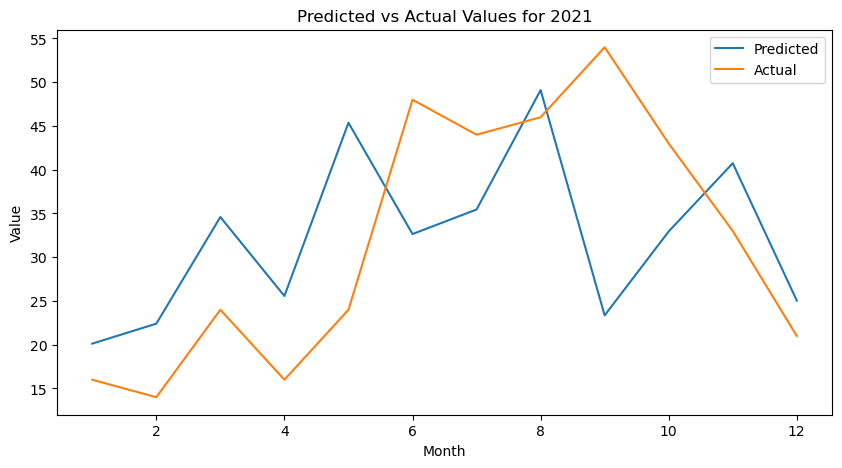

In [48]:
import warnings
warnings.filterwarnings('ignore')

predictions = {}
actuals = {}

# I skipped this line before so I am doing it now
toBeUsedForTesting['Date'] = pd.to_datetime(toBeUsedForTesting['year'].astype(str) + "-" + toBeUsedForTesting['month'].astype(str) + "-01")

# Predicting the values for each month in 2021
for month in range(1, 13):
    prediction = predict_accidents(2021, month)
    actual = toBeUsedForTesting[(toBeUsedForTesting['Date'].dt.year == 2021) & (toBeUsedForTesting['Date'].dt.month == month)]['value'].values[0]
    predictions[month] = prediction.flatten()[0]  # flatten the prediction and take the first value
    actuals[month] = actual

# Plotting the predicted vs actual values for 2021
plt.figure(figsize=(10, 5))
plt.plot(list(predictions.keys()), list(predictions.values()), label='Predicted')
plt.plot(list(actuals.keys()), list(actuals.values()), label='Actual')
plt.xlabel('Month')
plt.ylabel('Value')
plt.title('Predicted vs Actual Values for 2021')
plt.legend()
plt.show()